In [212]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import ttest_ind_from_stats

In [187]:
df = pd.read_csv('stats.txt', sep=',')
df.head()

,problem_name,planning_time,plan_length
0,problems/problem-experiment_5x5_6_150_1/proble...,0.647604,13
1,problems/problem-experiment_5x5_6_150_1/proble...,0.819740,30
2,problems/problem-experiment_5x5_6_150_1/proble...,0.737229,24
3,problems/problem-experiment_5x5_6_150_1/proble...,0.633495,16
4,problems/problem-experiment_5x5_6_150_1/proble...,0.642722,9


In [188]:
df['is_subproblem'] = df['problem_name'].str.split('/').str.len() > 2
df['problem'] = df['problem_name'].str.split('/').str[-1]
df['size'] = df['problem'].str.split('_').str[1].str.split('x').str[0].astype(int)
df['keys_count'] = df['problem'].str.split('_').str[2].astype(int)

In [189]:
df_subproblems = df[df['is_subproblem']].copy()

df_subproblems['subproblem_part'] = df_subproblems['problem'].str.split('-').str[-1]
df_subproblems['problem'] = df_subproblems['problem'].str.split('-').str[:-1].str.join('-') + '.pddl'

df_subproblems_collected = df_subproblems.groupby(by=['problem', 'size', 'keys_count'])[['planning_time', 'plan_length']].sum().reset_index()

df_subproblems_collected['is_subproblem'] = True
df_subproblems_collected

,problem,size,keys_count,planning_time,plan_length,is_subproblem
0,problem-experiment_5x5_6_150_1-subproblem.pddl,5,6,4.045366,96,True
1,problem-experiment_5x5_6_150_10-subproblem.pddl,5,6,4.656749,117,True
2,problem-experiment_5x5_6_150_2-subproblem.pddl,5,6,5.256875,103,True
3,problem-experiment_5x5_6_150_3-subproblem.pddl,5,6,5.090151,114,True
4,problem-experiment_5x5_6_150_4-subproblem.pddl,5,6,3.844271,50,True
...,...,...,...,...,...,...
65,problem-experiment_7x7_6_150_5-subproblem.pddl,7,6,31.141544,213,True
66,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,244.312817,404,True
67,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,64.536248,109,True
68,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,96.147081,284,True


In [190]:
df_collected = pd.concat([df[~df['is_subproblem']], df_subproblems_collected], axis='rows')
df_collected['time_out'] = (df_collected['plan_length'] == -1).astype(float)

df_collected

,problem_name,planning_time,plan_length,is_subproblem,problem,size,keys_count,time_out
6,problems/problem-experiment_5x5_6_150_1.pddl,1.543421,168,False,problem-experiment_5x5_6_150_1.pddl,5,6,0.0
13,problems/problem-experiment_5x5_6_150_2.pddl,2.186317,136,False,problem-experiment_5x5_6_150_2.pddl,5,6,0.0
20,problems/problem-experiment_5x5_6_150_3.pddl,4.404218,318,False,problem-experiment_5x5_6_150_3.pddl,5,6,0.0
27,problems/problem-experiment_5x5_6_150_4.pddl,3.257369,210,False,problem-experiment_5x5_6_150_4.pddl,5,6,0.0
34,problems/problem-experiment_5x5_6_150_5.pddl,3.866662,280,False,problem-experiment_5x5_6_150_5.pddl,5,6,0.0
...,...,...,...,...,...,...,...,...
65,NaN,31.141544,213,True,problem-experiment_7x7_6_150_5-subproblem.pddl,7,6,0.0
66,NaN,244.312817,404,True,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,0.0
67,NaN,64.536248,109,True,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,0.0
68,NaN,96.147081,284,True,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,0.0


In [221]:
df_grouped = df_collected[df_collected['plan_length'] != -2].groupby(by=['size', 'keys_count', 'is_subproblem'])[['planning_time', 'time_out']]

df_means = df_grouped.mean().reset_index()
df_counts = df_grouped.count().reset_index()
df_std = df_grouped.std().reset_index()

df_joined = pd.merge(pd.merge(df_std, df_counts, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('_std', '_count')), df_means, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('', '_mean'))

df_joined['std_avg'] = df_joined['planning_time_std'] / np.sqrt(df_joined['planning_time_count'])
df_joined['time_out_std_avg'] = df_joined['time_out_std'] / np.sqrt(df_joined['time_out_count'])
df_joined

,size,keys_count,is_subproblem,planning_time_std,time_out_std,planning_time_count,time_out_count,planning_time,time_out,ttest,std_avg,time_out_std_avg
0,5,6,False,1.214234,0.000000,10,10,3.264696,0.0,1.0,0.383974,0.000000
1,5,6,True,3.864061,0.000000,10,10,6.257308,0.0,1.0,1.221923,0.000000
2,6,5,False,136.687857,0.000000,10,10,64.903376,0.0,1.0,43.224496,0.000000
3,6,5,True,12.412281,0.000000,10,10,13.948264,0.0,1.0,3.925108,0.000000
4,6,6,False,98.615023,0.316228,10,10,79.330658,0.1,1.0,31.184809,0.100000
5,6,6,True,6.405388,0.000000,10,10,11.420556,0.0,1.0,2.025561,0.000000
6,6,7,False,259.347485,0.483046,10,10,228.677498,0.3,1.0,82.012876,0.152753
7,6,7,True,10.864740,0.000000,10,10,16.073258,0.0,1.0,3.435732,0.000000
8,6,8,False,221.489446,0.316228,10,10,121.510717,0.1,1.0,70.041113,0.100000
9,6,8,True,7.767985,0.000000,10,10,17.412605,0.0,1.0,2.456452,0.000000


In [199]:
df_means_size6 = df_joined[df_joined['size'] == 6]
df_means_keys6 = df_joined[df_joined['keys_count'] == 6]

df_means_size6_subproblems = df_means_size6[df_means_size6['is_subproblem']]
df_means_size6_full_problems = df_means_size6[~df_means_size6['is_subproblem']]

df_means_keys6_subproblems = df_means_keys6[df_means_keys6['is_subproblem']]
df_means_keys6_full_problems = df_means_keys6[~df_means_keys6['is_subproblem']]

In [234]:
different_times_pvalues = df_joined.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['planning_time', 'planning_time_std', 'planning_time_count']).apply(
    lambda row:
           ttest_ind_from_stats(row['planning_time'][False], row['planning_time_std'][False], row['planning_time_count'][False],
                                row['planning_time'][True], row['planning_time_std'][True], row['planning_time_count'][True],
                                equal_var=False).pvalue, axis=1).reset_index(name='p_value')

different_times_pvalues

,size,keys_count,p_value
0,5,6,0.039900
1,6,5,0.270044
2,6,6,0.057575
3,6,7,0.029131
4,6,8,0.171536
5,6,9,0.331862
6,7,6,0.014052


In [194]:
df_means_size6_full_problems['keys_count']

2     5
4     6
6     7
8     8
10    9
Name: keys_count, dtype: int64

In [200]:
df_means_keys6_full_problems['size']

0     5
4     6
12    7
Name: size, dtype: int64

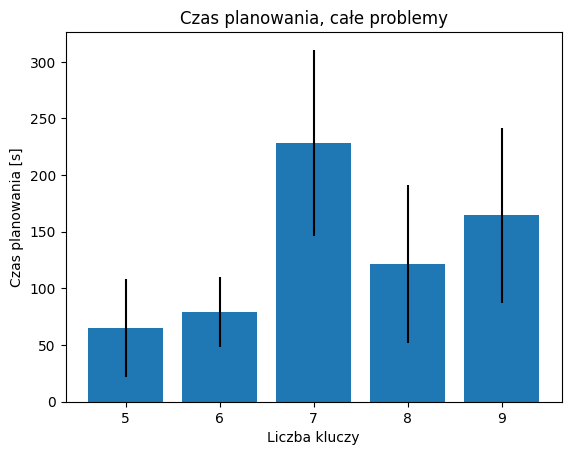

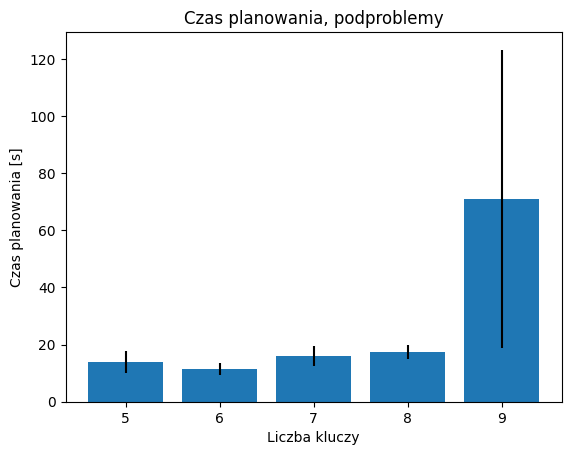

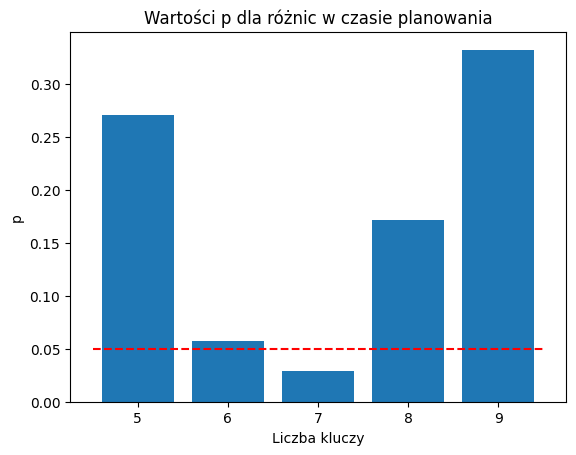

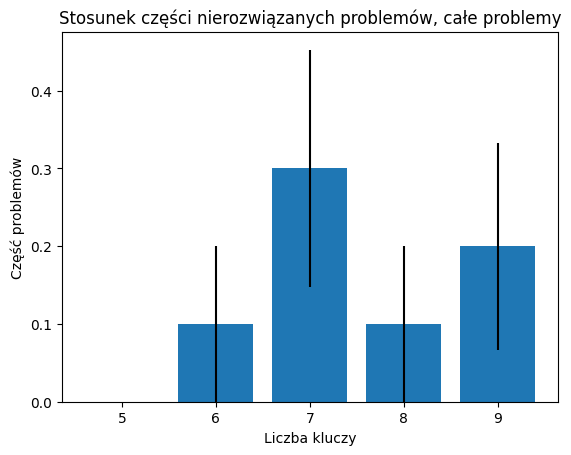

In [251]:
plt.title("Czas planowania, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['planning_time'], yerr=df_means_size6_full_problems['std_avg'])
plt.show()

plt.title("Czas planowania, podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_subproblems['keys_count'], df_means_size6_subproblems['planning_time'], yerr=df_means_size6_subproblems['std_avg'])
plt.show()

plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(different_times_pvalues['keys_count'], different_times_pvalues['p_value'])
plt.plot([min(different_times_pvalues['keys_count']) - 0.5, max(different_times_pvalues['keys_count']) + 0.5], [0.05, 0.05], 'r--')
plt.show()

plt.title("Stosunek części nierozwiązanych problemów, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Część problemów')
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['time_out'], yerr=df_means_size6_full_problems['time_out_std_avg'])
plt.show()

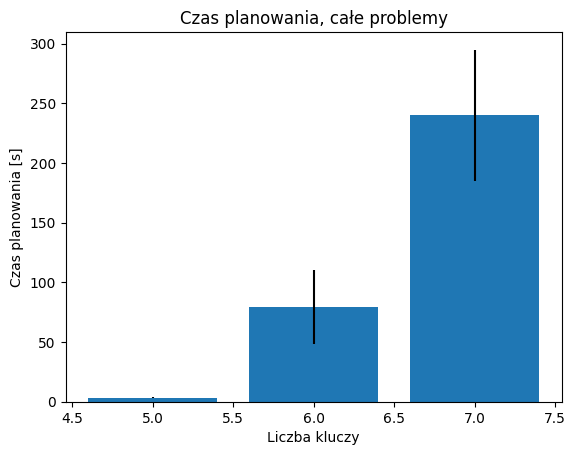

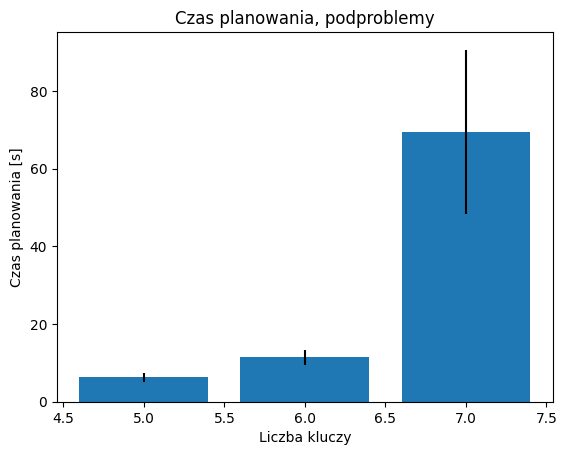

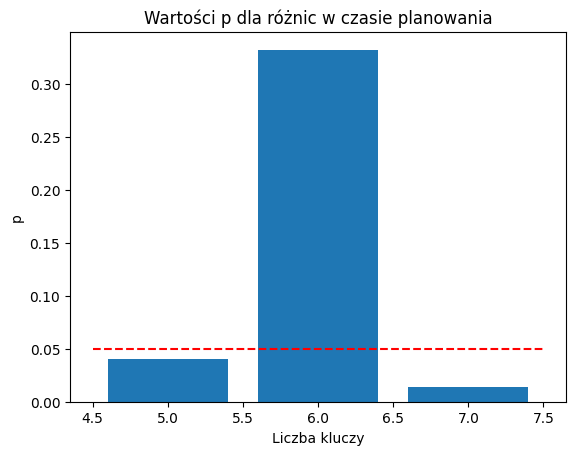

In [253]:
plt.title('Czas planowania, całe problemy')
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_full_problems['size'], df_means_keys6_full_problems['planning_time'], yerr=df_means_keys6_full_problems['std_avg'])
plt.show()

plt.title('Czas planowania, podproblemy')
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_subproblems['size'], df_means_keys6_subproblems['planning_time'], yerr=df_means_keys6_subproblems['std_avg'])
plt.show()

plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(different_times_pvalues['size'], different_times_pvalues['p_value'])
plt.plot([min(different_times_pvalues['size']) - 0.5, max(different_times_pvalues['size']) + 0.5], [0.05, 0.05], 'r--')
plt.show()